In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import pandas as pd
import seaborn
from sklearn.metrics import RocCurveDisplay

ORTHOPEDIA_DIR = "/mnt/dss/dssfs04/pn25ke/pn25ke-dss-0001/orthopedia"

In [2]:
def plot_histogram(array: np.ndarray, suffix: str) -> None:
    if not np.sum(array):
        return
    ax = seaborn.histplot(array - .5, bins=int(np.max(array)))
    ax.set_yscale("log")
    ax.set_title(f"Neutrophil count histogram ({suffix})")
    ax.set_xlabel("Neutrophil count in a tile")
    ax.set_ylabel("Occurence in the WSI")
    ax.set_xticks(range(int(np.max(array))))
    plt.show()
    
def box_plot(data: pd.DataFrame, y: str, title: str, ax: Axes):
    seaborn.boxplot(
        data=data,
        x="class",
        y=y,
        ax=ax,
    ).set_title(title)
    
def roc_curve(data: pd.DataFrame, y: str, title: str, ax: Axes):
    RocCurveDisplay.from_predictions(
        np.array(data["class"].str.startswith("infect")).astype(int),
        data[y],
        name=f"{y} vs the rest",
        color="darkorange",
        ax=ax,
    )
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    ax.axis('equal')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend(loc="lower right")

In [3]:
histograms = {
    "infect": dict(),
    "noinfect": dict(),
}

for key in histograms:
    key_path = os.path.join(ORTHOPEDIA_DIR, f"{key}_inference")
    for fn_folder in os.listdir(key_path):
        fn_path = os.path.join(key_path, fn_folder)
        if len(os.listdir(fn_path)) == 0:
            print("Skipping", fn_path)
            continue
        histograms[key][fn_folder] = np.concatenate([np.load(os.path.join(fn_path, f)) for f in os.listdir(fn_path)])

In [4]:
for key in histograms:
    print(f"{key} mean: {np.mean([np.mean(item) for item in histograms[key].values()]):.3f}")

infect mean: 0.353
noinfect mean: 0.108


In [5]:
array_iter = iter(histograms["infect"].values())

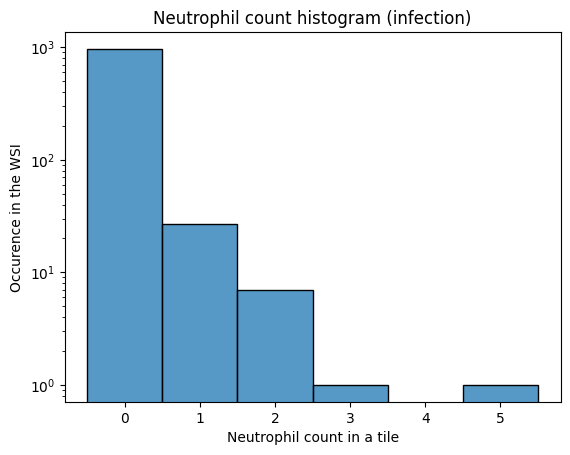

In [6]:
plot_histogram(next(array_iter), "infection")

In [17]:
for key in histograms:
    top_5_mean = [
        (p_id, np.mean(histograms[key][p_id][np.argpartition(histograms[key][p_id], -5)[-5:]]))
        for p_id in histograms[key]
    ]
    top_5_mean.sort(key=lambda x: x[1], reverse=key == "noinfect")
    print(key)
    print(top_5_mean)

infect
[('9664556978', 0.0), ('9661385040', 2.0), ('9660600803', 2.0), ('9662138506', 2.4), ('9661120888', 2.6), ('9660838767', 2.6), ('9660673094', 3.0), ('9661316412', 3.6), ('9666865131', 4.2), ('9660721556', 4.6), ('9662236645', 5.2), ('9661389539', 5.6), ('9660977668', 6.2), ('9662880458', 7.0), ('9666764258', 7.6), ('9660937824', 8.4), ('9660535417', 9.6), ('9661041731', 10.2), ('9660563760', 11.0), ('9665673832', 12.6), ('9660869167', 13.8), ('9661376769', 14.6), ('9661228390', 16.0), ('9660562210', 17.0), ('9662118375', 18.6), ('9661181594', 19.4), ('9661158535', 23.8), ('9662345131', 40.4), ('9655360508', 41.0), ('9660782850', 47.0)]
noinfect
[('9662244895', 45.2), ('9663172753', 12.2), ('9662086989', 10.8), ('9661530352', 9.0), ('9662085390', 8.4), ('9663222055', 8.4), ('9661532821', 5.8), ('9662908494', 5.6), ('9661392877', 5.6), ('9661756908', 5.0), ('9661818566', 4.8), ('9662552476', 4.6), ('9662059255', 4.6), ('9661859461', 4.0), ('9660809415', 3.8), ('9661120724', 3.8), 

In [7]:
dfs = [
    pd.DataFrame.from_dict({
        "mean neutrophil count": [np.mean(item) for item in histograms[key].values()],
        "top 10 mean neutrophil count": [np.mean(item[np.argpartition(item, -10)[-10:]]) for item in histograms[key].values()],
        "top 5 mean neutrophil count": [np.mean(item[np.argpartition(item, -5)[-5:]]) for item in histograms[key].values()],
        "max neutrophil count": [np.max(item) for item in histograms[key].values()],
        "class": [f"{key} ({len(histograms[key])} samples)"] * len(histograms[key])
    })
    for key in histograms
]

In [8]:
pd.concat(dfs)

,mean neutrophil count,top 10 mean neutrophil count,top 5 mean neutrophil count,max neutrophil count,class
0,0.050000,2.4,3.0,6.0,infect (30 samples)
1,0.000000,0.0,0.0,0.0,infect (30 samples)
2,0.841000,16.8,19.4,31.0,infect (30 samples)
3,0.251286,12.3,13.8,16.0,infect (30 samples)
4,0.092000,3.3,4.2,5.0,infect (30 samples)
...,...,...,...,...,...
61,0.167625,33.1,45.2,62.0,noinfect (66 samples)
62,0.060000,1.2,1.4,2.0,noinfect (66 samples)
63,0.018000,1.2,1.4,2.0,noinfect (66 samples)
64,0.090000,1.9,2.2,3.0,noinfect (66 samples)


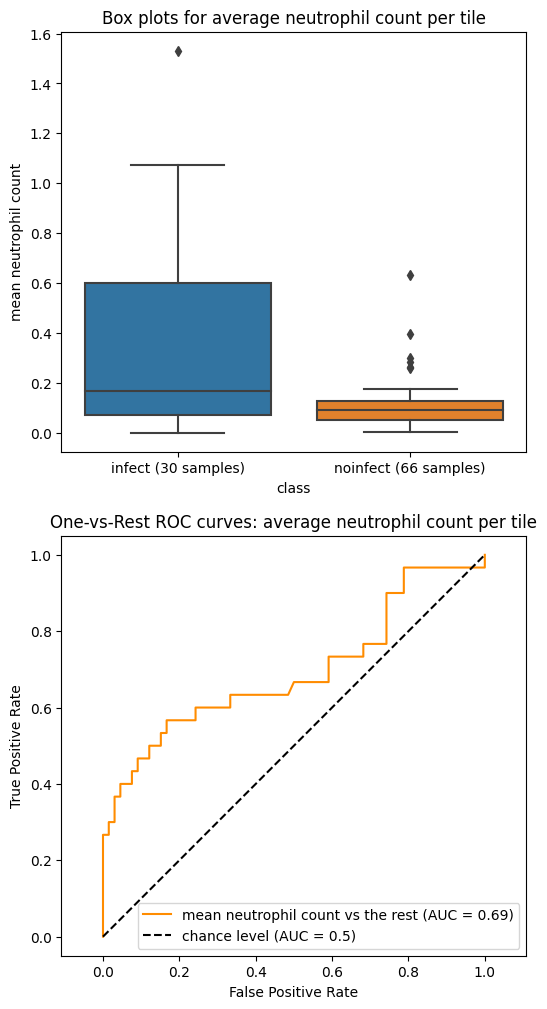

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
box_plot(
    data=pd.concat(dfs),
    y="mean neutrophil count",
    title="Box plots for average neutrophil count per tile",
    ax=axes[0]
)
roc_curve(
    data=pd.concat(dfs),
    y="mean neutrophil count",
    title="One-vs-Rest ROC curves: average neutrophil count per tile",
    ax=axes[1]
)
plt.show()

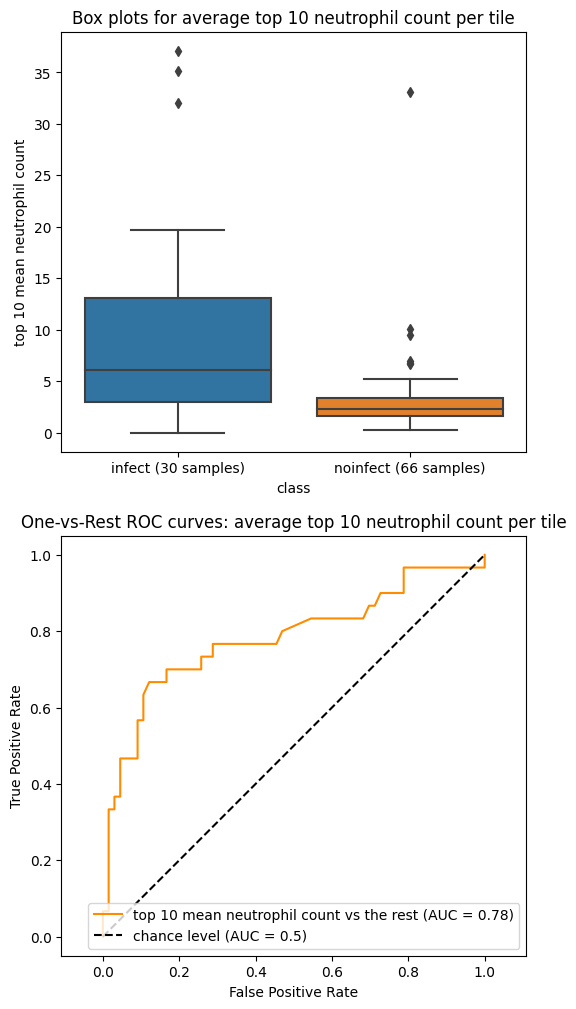

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
box_plot(
    data=pd.concat(dfs),
    y="top 10 mean neutrophil count",
    title="Box plots for average top 10 neutrophil count per tile",
    ax=axes[0]
)
roc_curve(
    data=pd.concat(dfs),
    y="top 10 mean neutrophil count",
    title="One-vs-Rest ROC curves: average top 10 neutrophil count per tile",
    ax=axes[1]
)
plt.show()

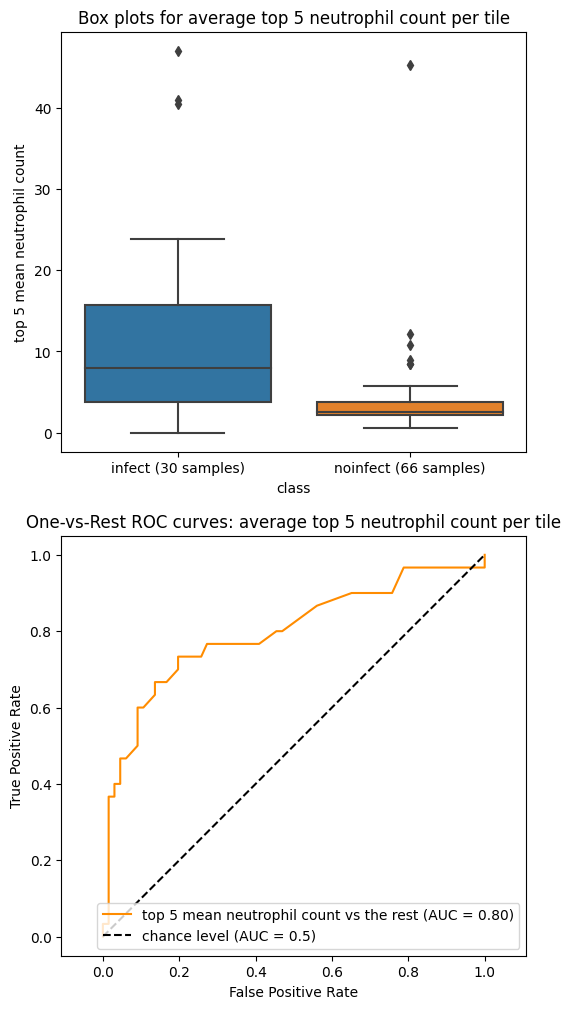

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))
box_plot(
    data=pd.concat(dfs),
    y="top 5 mean neutrophil count",
    title="Box plots for average top 5 neutrophil count per tile",
    ax=axes[0]
)
roc_curve(
    data=pd.concat(dfs),
    y="top 5 mean neutrophil count",
    title="One-vs-Rest ROC curves: average top 5 neutrophil count per tile",
    ax=axes[1]
)
plt.show()

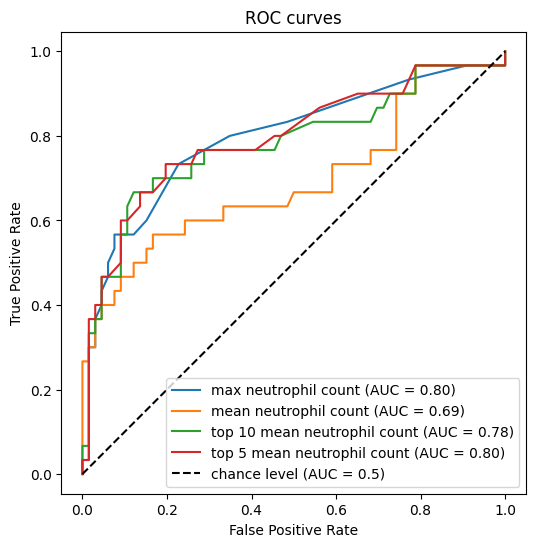

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
data = pd.concat(dfs)
for y in ["max neutrophil count", "mean neutrophil count", "top 10 mean neutrophil count", "top 5 mean neutrophil count"]:
    RocCurveDisplay.from_predictions(
        np.array(data["class"].str.startswith("infect")).astype(int),
        data[y],
        name=y,
        # color="darkorange",
        ax=ax,
    )
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.axis('equal')
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC curves")
ax.legend(loc="lower right")
plt.show()